# Batch Normalization

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

SyntaxError: invalid syntax (layers.py, line 242)

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

y_val:  (1000,)
y_test:  (1000,)
x_test:  (1000, 3, 32, 32)
x_train:  (49000, 3, 32, 32)
x_val:  (1000, 3, 32, 32)
y_train:  (49000,)


## Batch Normalization: Forward

In [3]:
# Check the training-time forward pass by checking means and variances of features both before and after batch
# normaliztion.

# Simulate the forward pass for a two-layer network.
N, D1, D2, D3 = 200, 50, 60, 3
x = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, x.dot(W1)).dot(W2)

print('Before batch normalization: ')
print('  means: ', a.mean(axis = 0))
print('  stds:  ', a.std(axis = 0))

# Means should be close to zero and stds close to one.
print('After batch normalization (gamma = 1, beta = 0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis = 0))
print('  std:  ', a_norm.std(axis = 0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta): ')
print('  means: ', a_norm.mean(axis = 0))
print('  stds:  ', a_norm.std(axis = 0))

Before batch normalization: 
  means:  [ -6.19889532  41.03409833  -5.89454445]
  stds:   [ 31.80254443  32.95715414  31.87644257]
After batch normalization (gamma = 1, beta = 0)
  mean:  [ -2.15799600e-17   6.77236045e-17   1.33226763e-17]
  std:   [ 1.  1.  1.]
After batch normalization (nontrivial gamma, beta): 
  means:  [ 11.  12.  13.]
  stds:   [ 1.          1.99999999  2.99999999]


In [4]:
# Check the test-time forward pass by running the training-time forward pass many times to warm up the running 
# averages, and then checking the means and variances of activations after a test-time forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
    x = np.random.randn(N, D1)
    a = np.maximum(0, x.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = np.random.randn(N, D1)
a = np.maximum(0, x.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [-0.04847613 -0.13151155 -0.07613046]
  stds:  [ 0.9853108   0.96305686  1.01564883]


## Batch Normalization: Backward

In [5]:
# Gradient check batchnorm backward pass

N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.3726174816e-09
dgamma error:  2.44945535792e-12
dbeta error:  3.7081064963e-12


## Batch Normalization: alternative backward

In [7]:
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  1.13340173882e-12
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 1.15x


## Fully Connected Nets with Batch Normalization

In [56]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
x = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim = D, num_classes = C, 
                              reg = reg, weight_scale = 5e-2, dtype = np.float64,
                              use_batchnorm = True)

    loss, grads = model.loss(x, y)
    print('Initial loss: ', loss)

    for name in sorted(grads): 
        f = lambda _: model.loss(x, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    if reg == 0: 
        print

Running check with reg =  0
Initial loss:  2.13096256209
W1 relative error: 9.51e-05
W2 relative error: 3.38e-06
W3 relative error: 3.77e-10
b1 relative error: 2.78e-09
b2 relative error: 2.22e-08
b3 relative error: 1.23e-10
beta1 relative error: 4.15e-08
beta2 relative error: 6.32e-09
gamma1 relative error: 1.13e-07
gamma2 relative error: 6.56e-09
Running check with reg =  3.14
Initial loss:  6.98269533741
W1 relative error: 2.42e-05
W2 relative error: 6.03e-07
W3 relative error: 2.93e-08
b1 relative error: 1.78e-07
b2 relative error: 5.55e-09
b3 relative error: 4.82e-10
beta1 relative error: 2.38e-09
beta2 relative error: 4.15e-09
gamma1 relative error: 2.45e-09
gamma2 relative error: 1.25e-08


## Batchnorm for deep networks

In [59]:
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 10000
small_data = {
    'x_train': data['x_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'x_val': data['x_val'],
    'y_val': data['y_val'],
}

weight_scale = 1e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale = weight_scale, use_batchnorm = True)
model = FullyConnectedNet(hidden_dims, weight_scale = weight_scale, use_batchnorm = False)

bn_solver = Solver(bn_model, small_data, num_epochs = 50, batch_size = 50, update_rule = 'adam', 
                  optim_config = {'learning_rate': 1e-3}, verbose = True, print_every = 200)
bn_solver.train()

solver = Solver(model, small_data, num_epochs = 50, batch_size = 50, update_rule = 'adam', 
                optim_config = {'learning_rate': 1e-3}, verbose = True, print_every = 200)
solver.train()

(Iteration 1 / 10000) loss: 2.299070
(Epoch 0 /50) train acc: 0.089000; val_acc: 0.099000
(Epoch 1 /50) train acc: 0.388000; val_acc: 0.350000
(Iteration 201 / 10000) loss: 1.667954
(Epoch 2 /50) train acc: 0.418000; val_acc: 0.412000
(Iteration 401 / 10000) loss: 1.353717
(Epoch 3 /50) train acc: 0.462000; val_acc: 0.401000
(Iteration 601 / 10000) loss: 1.236450
(Epoch 4 /50) train acc: 0.500000; val_acc: 0.420000
(Iteration 801 / 10000) loss: 1.399776
(Epoch 5 /50) train acc: 0.535000; val_acc: 0.433000
(Iteration 1001 / 10000) loss: 1.731163
(Epoch 6 /50) train acc: 0.571000; val_acc: 0.451000
(Iteration 1201 / 10000) loss: 1.216819
(Epoch 7 /50) train acc: 0.594000; val_acc: 0.451000
(Iteration 1401 / 10000) loss: 1.172481
(Epoch 8 /50) train acc: 0.610000; val_acc: 0.443000
(Iteration 1601 / 10000) loss: 1.056839
(Epoch 9 /50) train acc: 0.645000; val_acc: 0.455000
(Iteration 1801 / 10000) loss: 0.998873
(Epoch 10 /50) train acc: 0.692000; val_acc: 0.465000
(Iteration 2001 / 10000

(Epoch 37 /50) train acc: 0.848000; val_acc: 0.434000
(Iteration 7401 / 10000) loss: 0.493473
(Epoch 38 /50) train acc: 0.877000; val_acc: 0.423000
(Iteration 7601 / 10000) loss: 0.368155
(Epoch 39 /50) train acc: 0.872000; val_acc: 0.439000
(Iteration 7801 / 10000) loss: 0.364162
(Epoch 40 /50) train acc: 0.847000; val_acc: 0.426000
(Iteration 8001 / 10000) loss: 0.355702
(Epoch 41 /50) train acc: 0.855000; val_acc: 0.428000
(Iteration 8201 / 10000) loss: 0.456170
(Epoch 42 /50) train acc: 0.859000; val_acc: 0.413000
(Iteration 8401 / 10000) loss: 0.671121
(Epoch 43 /50) train acc: 0.853000; val_acc: 0.428000
(Iteration 8601 / 10000) loss: 0.491668
(Epoch 44 /50) train acc: 0.867000; val_acc: 0.435000
(Iteration 8801 / 10000) loss: 0.496607
(Epoch 45 /50) train acc: 0.891000; val_acc: 0.427000
(Iteration 9001 / 10000) loss: 0.720122
(Epoch 46 /50) train acc: 0.903000; val_acc: 0.415000
(Iteration 9201 / 10000) loss: 0.295772
(Epoch 47 /50) train acc: 0.884000; val_acc: 0.432000
(Itera

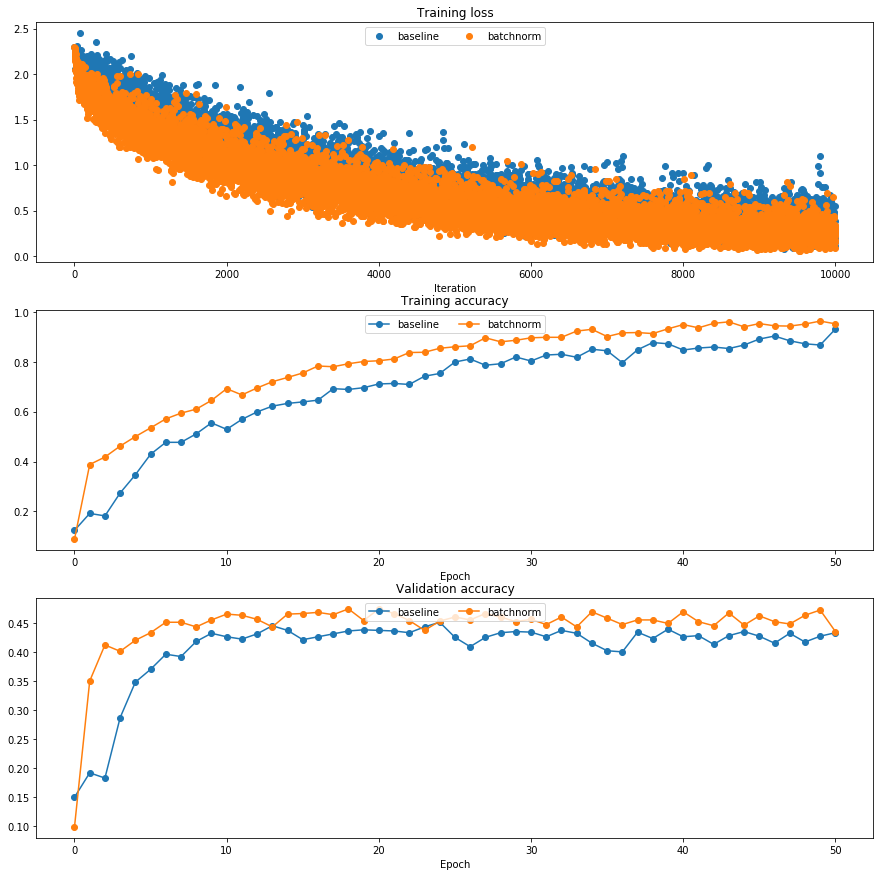

In [60]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label='baseline')
plt.plot(bn_solver.loss_history, 'o', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Batch normalization and initialization

In [63]:
# Try training a very deep net with batchnorm
hidden_dims = [50, 100, 100, 100, 50, 50, 50]

num_train = 10000
small_data = {
    'x_train': data['x_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'x_val': data['x_val'],
    'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num = 20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale = weight_scale, use_batchnorm = True)
    model = FullyConnectedNet(hidden_dims, weight_scale = weight_scale, use_batchnorm = False)
    
    bn_solver = Solver(bn_model, small_data, num_epochs = 20, batch_size = 50, update_rule = 'adam', 
                      optim_config = {'learning_rate': 1e-3}, verbose = False, print_every = 200)
    bn_solver.train()
    bn_solvers[weight_scale] = bn_solver
    
    solver = Solver(bn_model, small_data, num_epochs = 20, batch_size = 50, update_rule = 'adam', 
                    optim_config = {'learning_rate': 1e-3}, verbose = False, print_every = 200)
    solver.train()
    solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


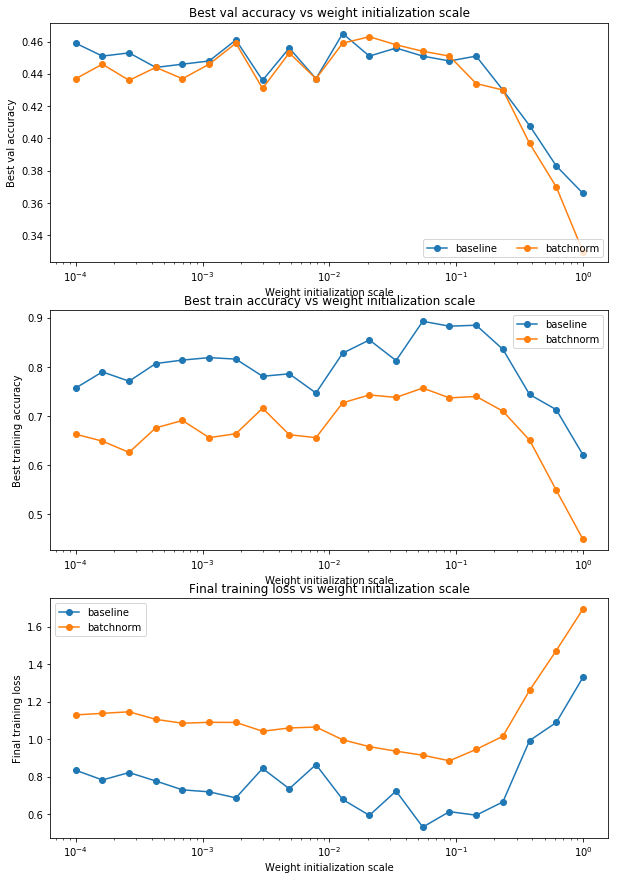

In [64]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(solvers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))
    
    best_val_accs.append(max(solvers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))
    
    final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))

plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()